In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from src.data.analyse import *
from ema_workbench import load_results
sns.set_theme(style="ticks")

## Load results

In [4]:
# Load results
results = load_results('../results/scenarios=5, policies=20.tar.gz')

# Prepare outcomes data frame
outcomes = prepare_outcomes(results, add_policies=True)

# This outcome should be studied separately
outcomes.drop('years_in_poverty', axis=1, inplace=True)

# Convert columns of interest to float
for col in outcomes.columns:
    if col not in ['scenario', 'policy', 'district', 'my_policy']:
        outcomes[col] = outcomes[col].astype(float)

## EDA

In [5]:
outcomes[['target_group', 'top_up']] = outcomes['my_policy'].str.split('+', expand=True)
outcomes['top_up'] = pd.Categorical(outcomes['top_up'], categories=['0', '10', '30', '50', '100'])
outcomes['annual_average_consumption_loss_pct'] = outcomes['annual_average_consumption_loss_pct'] * 100
outcomes['initial_poverty_gap'] = outcomes['initial_poverty_gap'] * 100
outcomes['new_poverty_gap'] = outcomes['new_poverty_gap'] * 100
outcomes = outcomes.assign(n_new_poor_increase_pct = outcomes['n_new_poor'].div(outcomes['total_population']).multiply(100))

In [6]:
policies = ['0', '10', '30', '50', '100']
target_groups = [
                 'all', 
                 'poor', 
                 'poor_near_poor1.25', 
                 'poor_near_poor2.0'
                 ]
table = {}
for target_group in target_groups:
    d = {}
    for policy in policies:
        df = outcomes[outcomes['top_up'] == policy]
        df = df[df['target_group'] == target_group]
        columns_of_interest = ['district', 'n_poor_initial', 'n_new_poor']
        df.round(2)[columns_of_interest].groupby('district').median()
        d[policy] = (df['n_new_poor'].sum() / df['n_poor_initial'].sum() * 100)
    table[target_group] = d

In [7]:
vertical = ['None', '10%', '30%', '50%', '100%']
horizontal = ['All', 'Poor', 'Poor & Near Poor (1.25)', 'Poor & Near Poor (2.0)']
columns = ['Vertical expansion', 'Horizontal expansion', 
           'Average reduction in consumption loss (%)', 
           'Average number of people prevented from falling into poverty']

In [8]:
table = pd.DataFrame(table).round(2)
table

,all,poor,poor_near_poor1.25,poor_near_poor2.0
0,4.04,4.04,4.04,4.04
10,2.20,4.04,3.47,2.37
30,0.03,4.04,1.71,0.20
50,0.00,4.04,1.68,0.17
100,0.00,4.04,1.68,0.17


In [9]:
# When top up == 0 it doesn't matter what is the target group
# df = outcomes[outcomes['top_up'] == '0']
df = outcomes.copy()
df = df[df['district'] == 'AnseLaRayeCanaries']
# df = df[df['target_group'] == 'all']
columns_of_interest = [
       'district',
       'target_group',
       'top_up', 
      #  'total_population',
      #  'total_asset_loss', 'total_consumption_loss', 'event_damage',
      #  'total_asset_stock', 'average_productivity', 'total_asset_in_survey',
      #  'expected_loss_fraction', 
      #  'n_affected_people',
      #  'annual_average_consumption', 'poverty_line_adjusted', 'pml', 
      #  'n_poor_initial', 'n_poor_affected', 
       'n_new_poor',
       'n_new_poor_increase_pct', 
       'initial_poverty_gap', 
       'new_poverty_gap', 
      #  'annual_average_consumption_loss',
       'annual_average_consumption_loss_pct', 
       'r'
       ]
df[columns_of_interest].round(2).groupby(['target_group', 'top_up', 'district']).mean()

n_new_poor  \
target_group       top_up district                         
all                0      AnseLaRayeCanaries       115.4   
                   10     AnseLaRayeCanaries        58.0   
                   30     AnseLaRayeCanaries         0.0   
                   50     AnseLaRayeCanaries         0.0   
                   100    AnseLaRayeCanaries         0.0   
poor               0      AnseLaRayeCanaries       115.4   
                   10     AnseLaRayeCanaries       115.4   
                   30     AnseLaRayeCanaries       115.4   
                   50     AnseLaRayeCanaries       115.4   
                   100    AnseLaRayeCanaries       115.4   
poor_near_poor1.25 0      AnseLaRayeCanaries       115.4   
                   10     AnseLaRayeCanaries        95.2   
                   30     AnseLaRayeCanaries        37.4   
                   50     AnseLaRayeCanaries        37.4   
                   100    AnseLaRayeCanaries        37.4   
poor_near_poor2.0  0      AnseLaRayeCanaries       115.4   
                   10     AnseLaRayeCanaries        58.0   
                   30     AnseLaRayeCanaries         0.0   
                   50     AnseLaRayeCanaries         0.0   
                   100    AnseLaRayeCanaries         0.0   

                                              n_new_poor_increase_pct  \
target_group       top_up district                                      
all                0      AnseLaRayeCanaries                    1.332   
                   10     AnseLaRayeCanaries                    0.670   
                   30     AnseLaRayeCanaries                    0.000   
                   50     AnseLaRayeCanaries                    0.000   
                   100    AnseLaRayeCanaries                    0.000   
poor               0      AnseLaRayeCanaries                    1.332   
                   10     AnseLaRayeCanaries                    1.332   
                   30     AnseLaRayeCanaries                    1.332   
                   50     AnseLaRayeCanaries                    1.332   
                   100    AnseLaRayeCanaries                    1.332   
poor_near_poor1.25 0      AnseLaRayeCanaries                    1.332   
                   10     AnseLaRayeCanaries                    1.100   
                   30     AnseLaRayeCanaries                    0.432   
                   50     AnseLaRayeCanaries                    0.432   
                   100    AnseLaRayeCanaries                    0.432   
poor_near_poor2.0  0      AnseLaRayeCanaries                    1.332   
                   10     AnseLaRayeCanaries                    0.670   
                   30     AnseLaRayeCanaries                    0.000   
                   50     AnseLaRayeCanaries                    0.000   
                   100    AnseLaRayeCanaries                    0.000   

                                              initial_poverty_gap  \
target_group       top_up district                                  
all                0      AnseLaRayeCanaries               32.850   
                   10     AnseLaRayeCanaries               32.020   
                   30     AnseLaRayeCanaries               30.352   
                   50     AnseLaRayeCanaries               28.690   
                   100    AnseLaRayeCanaries               24.532   
poor               0      AnseLaRayeCanaries               32.850   
                   10     AnseLaRayeCanaries               32.020   
                   30     AnseLaRayeCanaries               30.352   
                   50     AnseLaRayeCanaries               28.690   
                   100    AnseLaRayeCanaries               24.532   
poor_near_poor1.25 0      AnseLaRayeCanaries               32.850   
                   10     AnseLaRayeCanaries               32.020   
                   30     AnseLaRayeCanaries               30.352   
                   50     AnseLaRayeCanaries               28.690   
              

In [10]:
target_group_names = {'all' : 'All', 'poor' : 'Poor', 'poor_near_poor1.25' : 'Poor and near-poor (1.25)', 'poor_near_poor2.0' : 'Poor and near-poor (2.0)'}
target_group = 'all'
df = outcomes[outcomes['target_group'] == target_group]

districts = df['district'].unique().tolist()
n_districts = len(districts)

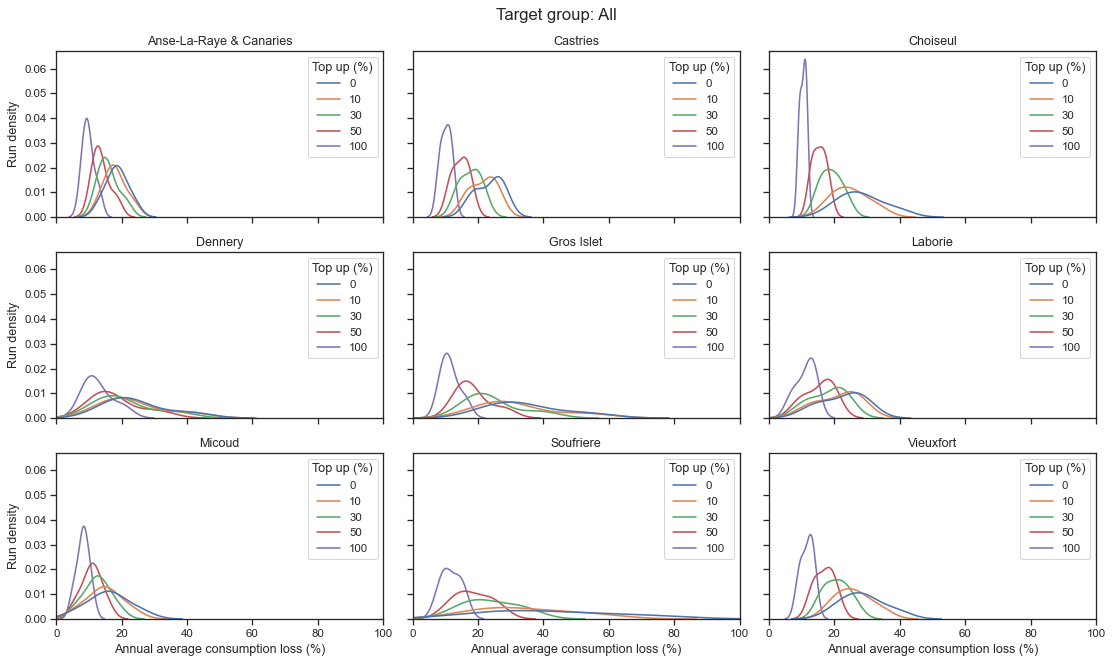

In [11]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

# outcome_of_interest = 'n_new_poor'
outcome_of_interest = 'annual_average_consumption_loss_pct'
outcome_to_outcome_name = {'annual_average_consumption_loss_pct': 'Annual average consumption loss (%)',
                           'n_new_poor': 'Number of new poor',
                           'n_new_poor_increase_pct' : 'Increase in number of new poor (%)'}

for district in districts:
    data = df[df['district'] == district][['top_up', outcome_of_interest]]
    data.sort_values('top_up', inplace=True)
    data.rename(columns={'top_up': 'Top up (%)'}, inplace=True)
    if district == 'AnseLaRayeCanaries':
        district_name = 'Anse-La-Raye & Canaries'
    else:
        district_name = district
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    # sns.histplot(data=data, 
    #              x=outcome_of_interest, 
    #              hue='Top up', 
    #              ax=ax[i, j], 
    #              # multiple='stack', 
    #              # shrink=.8,
    #              # palette="ch:rot=-.25,hue=1,light=.75"
    #              )
    sns.kdeplot(data=data, 
                 x=outcome_of_interest, 
                 hue='Top up (%)', 
                 ax=ax[i, j], 
                 )
    ax[i, j].set_title(district_name)
    ax[i, j].set_ylabel('Run density')
    ax[i, j].set_xlabel(outcome_to_outcome_name[outcome_of_interest])
    ax[i, j].set_xlim(0, 100)
fig.suptitle('Target group: ' + target_group_names[target_group], fontsize=16)
fig.tight_layout()